In [1]:
import random
import time
import gym
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import urllib.request

from torch.autograd import Variable
from collections import OrderedDict, deque
from tqdm import tqdm
from operator import add
from datetime import datetime

%matplotlib inline
np.set_printoptions(threshold=sys.maxsize)

/projects/academic/courses/cse546f21/anujarag/anaconda3/lib/python3.7/site-packages/ale_py/roms/utils.py:90: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for external in metadata.entry_points().get(self.group, []):


In [2]:
!mkdir models

mkdir: cannot create directory ‘models’: File exists


In [3]:
urllib.request.urlretrieve('http://www.atarimania.com/roms/Roms.rar','Roms.rar')
!pip install unrar
!unrar x Roms.rar
!mkdir rars
!mv HC\ ROMS.zip   rars
!mv ROMS.zip  rars
!python3 -m atari_py.import_roms rars

/bin/sh: unrar: command not found
mv: cannot stat ‘HC ROMS.zip’: No such file or directory
mv: cannot stat ‘ROMS.zip’: No such file or directory


In [4]:
class Actor_Network(nn.Module):

    def __init__(self, input_size, output_size, learning_rate, path = 'models/'):
        super(Actor_Network, self).__init__()
        self.path = path
 
        # self.linear_model = nn.Sequential(OrderedDict([
        #     ('conv1', nn.Conv2d(4, 32, kernel_size=8, stride=4)),
        #     ('relu1', nn.ReLU()),
        #     ('conv2', nn.Conv2d(32, 64, 4, 2)),
        #     ('relu2', nn.ReLU()),
        #     ('conv3', nn.Conv2d(64, 64, 3, 1)),
        #     ('relu3', nn.ReLU()),
        #     ('flatten1', nn.Flatten()),
        #     ('dense1', nn.Linear(7*7*64, 512)),
        #     ('relu4', nn.ReLU()),
        #     ('dense2', nn.Linear(512, output_size))]
        # ))
        self.linear_model = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(4, 8, kernel_size=8, stride=4)),
            ('relu1', nn.ReLU()),
            ('conv2', nn.Conv2d(8, 16, 4, 2)),
            ('relu2', nn.ReLU()),
            ('conv3', nn.Conv2d(16, 16, 3, 1)),
            ('relu3', nn.ReLU()),
            ('flatten1', nn.Flatten()),
            ('dense1', nn.Linear(7*7*16, 128)),
            ('relu4', nn.ReLU()),
            ('dense2', nn.Linear(128, output_size))]
        ))
        self.optimizer = optim.AdamW(self.parameters(),lr=lr)
        
    def forward(self, x):
        x = self.linear_model(x)
        output = F.softmax(x, dim = 1)
        return output
        
    def save_model(self,filename='a2c_actor_breakout.pth'):
        torch.save(self.state_dict(), self.path+filename)

    def load_model(self,filename='a2c_actor_breakout.pth'):
        self.load_state_dict(torch.load(self.path+filename))


In [5]:
class Critic_Network(nn.Module):

    def __init__(self, input_size, output_size, learning_rate, path = 'models/'):
        super(Critic_Network, self).__init__()
        self.path = path

        self.linear_model = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(4, 8, kernel_size=8, stride=4)),
            ('relu1', nn.ReLU()),
            ('conv2', nn.Conv2d(8, 16, 4, 2)),
            ('relu2', nn.ReLU()),
            ('conv3', nn.Conv2d(16, 16, 3, 1)),
            ('relu3', nn.ReLU()),
            ('flatten1', nn.Flatten()),
            ('dense1', nn.Linear(7*7*16, 128)),
            ('relu4', nn.ReLU()),
            ('dense2', nn.Linear(128, output_size))]
        ))
        self.optimizer = optim.AdamW(self.parameters(),lr=lr)
        
    def forward(self, x):
        x = self.linear_model(x)
        return x
        
    def save_model(self,filename='a2c_critic_breakout.pth'):
        torch.save(self.state_dict(), self.path+filename)

    def load_model(self,filename='a2c_critic_breakout.pth'):
        self.load_state_dict(torch.load(self.path+filename))

In [16]:
class DQNagent:
    '''
    DQNagent is a class that defines the agent.
    '''
    def __init__(self, state_size, action_size, batch_size, lr, discount_factor, memory_len):
        '''
        Initialize all the parameters that will be used in the learning phase.
        Initital two DQN networks - one is the policy network and the other is the target network
        '''
        self.state_size = state_size
        self.action_size = action_size
        
        self.memory = deque(maxlen=memory_len)
        
        # self.epsilon = epsilon
        # self.epsilon_decay = epsilon_decay
        # self.epsilon_min = 0.01
        self.batch_size = batch_size
        self.learning_rate = lr
        self.discount_factor = discount_factor
        
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        
        self.actor_network = Actor_Network(self.state_size, self.action_size, self.learning_rate).to(self.device)
        self.critic_network = Critic_Network(self.state_size, 1, self.learning_rate).to(self.device)
        
    def get_action(self, observation):
        '''
        This function defines epsilon greedy behavior of the agent.
        '''
        probs = self.actor_network.forward(observation)
        actions_probabilities = torch.distributions.Categorical(probs)
        action = actions_probabilities.sample()
        log_probability = actions_probabilities.log_prob(action)
        return action.cpu().detach().numpy()[0], log_probability
    
    def append_memory(self, state, action, reward, next_state, done, log_probability):
        '''
        Save each experience in the replay memory
        '''
        self.memory.append((state, action, reward, next_state, done, log_probability))
    
    # def update_target_policy(self):
    #     '''
    #     Update the target network parameters based on the policy network parameters
    #     '''
    #     self.target_net.load_state_dict(self.policy_net.state_dict())
    
    def update_epsilon(self):
        '''
        Perform epsilon decay
        '''
        self.epsilon -= (self.epsilon * self.epsilon_decay)
        return self.epsilon
    
    def preprocess_state(self, state):
        img = state[34:-16, :, :]
        resize = T.Compose([
                    T.ToPILImage(),
                    T.Grayscale(),
                    T.Resize((84, 84)),
                    T.ToTensor()
                ])
        img = resize(img)
        return img.to(self.device)

    def train_model(self):
        '''
        Train the agent
        '''
        if len(self.memory) > self.batch_size:
            mini_batch = random.sample(self.memory, self.batch_size)
            current_state = torch.tensor([]).float().to(self.device)
            actions = list()
            rewards = list()
            next_states = torch.tensor([]).float().to(self.device)
            dones = list()
            log_probability = list()
            
            # Append each memory values in the separate lists
            for i in range(self.batch_size):
                state, action, reward, next_state, done_boolean, log_prob = mini_batch[i]
                current_state = torch.cat((current_state, state)).float().to(self.device)
                actions.append(action)
                rewards.append(reward)
                next_states = torch.cat((next_states, next_state)).float().to(self.device)
                dones.append(done_boolean)
                log_probability.append(log_prob)
            
            # Convert each list to torch tensors
            actions = torch.from_numpy(np.array(actions)).to(self.device)
            rewards = torch.from_numpy(np.array(rewards)).float().to(self.device)
            dones = torch.from_numpy(np.array(dones)).to(self.device)
            log_probability = torch.stack(log_probability, dim=0).to(self.device)

            current_state_value = self.critic_network.forward(current_state)
            next_state_value = self.critic_network.forward(next_states)
            
            current_state_value = torch.squeeze(current_state_value)
            next_state_value = torch.squeeze(next_state_value)
            
            delta = list()
            for index in range(len(current_state_value)):
                if dones[index]:
                    delta.append(rewards[index] - current_state_value[index])
                else:
                    delta.append(rewards[index] + self.discount_factor * next_state_value[index] - current_state_value[index])
            delta = torch.stack(delta, dim=0)
            
            critic_loss = 0
            for i in delta:
                critic_loss += (i ** 2)
            critic_loss = critic_loss.mean()

            self.critic_network.optimizer.zero_grad()
            critic_loss.backward(retain_graph=True)
            self.critic_network.optimizer.step()

            actor_loss = []
            for i in range(len(current_state_value)):
                actor_loss.append(-log_probability * delta[i].detach())
            actor_loss = torch.stack(actor_loss, dim=0)
            actor_loss = torch.mean(actor_loss)
            var_actor_loss = Variable(actor_loss.data, requires_grad=True)
            self.actor_network.optimizer.zero_grad()
            var_actor_loss.backward(retain_graph=True)
            self.actor_network.optimizer.step()
    
    def test_model(self, agent, env, episodes, perform_render=False):
        '''
        Test the agent behavior after it has been trained
        Agent follows only the greedy policy
        '''
        
        total_reward_arr = list()
        timesteps = 0
        
        for episode in range(episodes):
            current_state = env.reset()

            obs, _, _, _ = env.step(1)
            current_state = agent.preprocess_state(obs)
            current_state = torch.cat((current_state, current_state, current_state, current_state)).unsqueeze(0)

            dead = False
            done = False
            total_reward = 0
            agent_lives = 5
            
            while not done:
                action, log_probability = self.get_action(current_state)
                
                next_state, reward, done, info = env.step(action)
                next_state = agent.preprocess_state(next_state) # 84-84
                next_state_history = torch.cat((current_state.squeeze(0)[1:, :, :], next_state)).unsqueeze(0) # 1-4-84-84

                if agent_lives > info['lives']:
                    dead = True
                    agent_lives = info['lives']

                if dead:
                    obs, _, _, _ = env.step(1)
                    obs = agent.preprocess_state(obs)
                    current_state = torch.cat((current_state.squeeze(0)[2:, :, :], next_state, obs)).unsqueeze(0)
                    dead = False
                else:
                    current_state = next_state_history

                total_reward += reward
                
                # Render only for the final episode
                if perform_render and episodes-1 == episode:
                    env.render()
            
            total_reward_arr.append(total_reward)
        return total_reward_arr0

In [7]:
def plot_graphs(title, total_reward, epsilon_decay, cumulative_reward, avg_timestep, episodes):
    '''
    This functions plots the graphs for rewards, epsilon, success, failure and avergae timesteps
    
    Success is defined when the agent has reached the goal state
    Failure is defined when the agent meets the monster or falls in the pit
    '''
    
    fig, axs = plt.subplots(1,2, figsize=(15,7))
    fig.suptitle(title, fontsize=18)
    fig.tight_layout()
    fig.subplots_adjust(top=0.85, hspace=0.2, wspace=0.2)
    
    axs[0].plot(avg_timestep)
    axs[0].set_title('Average timesteps per 50 episodes')
    axs[0].set_xticks(np.arange(len(avg_timestep)))
    axs[0].set_xticklabels(list(range(0,episodes+1,50))[1:], rotation=90)
    axs[0].set_xlabel('Episodes')
    axs[0].set_ylabel('Timesteps')
    
    axs[1].plot(total_reward)
    axs[1].set_title('Total Reward per episode')
    axs[1].set_xlabel('Episodes')
    axs[1].set_ylabel('Rewards')
    
    plt.show()

In [8]:
# Parameters
env = gym.make('BreakoutDeterministic-v4')
state_size = env.observation_space.shape
action_size = env.action_space.n

batch_size = 32
lr = 0.0001
discount_factor = 0.99
update_frequency = 5

memory_len = 100000
episodes = 50000
test_episodes = 100
perform_render = False

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

total_reward_arr = list() # Store total reward per episode values
cumulative_reward_arr = list() # Store cumulative reward
epsilon_decay_arr = [] # Store each epsilon value after decay
timestep_arr = list() # Store the timestep per episode
avg_timestep_arr = list() # Store average timestep every 20 episodes
test_total_reward_arr = list()

agent = DQNagent(state_size, action_size, batch_size, lr, discount_factor, memory_len)
success_count = 0
failure_count = 0
train_timestep = 12

for episode in tqdm(range(episodes)):
    done = False
    dead = False
    # perform_fire = True

    total_reward = 0
    timesteps = 0
    agent_lives = 5
    env = gym.make('BreakoutDeterministic-v4')
    current_state = env.reset() 

    obs, _, _, _ = env.step(1)
    current_state = agent.preprocess_state(obs)
    current_state = torch.cat((current_state, current_state, current_state, current_state)).unsqueeze(0) # 1-4-84-84
    # print(f'\nEpisode: {episode}, Agent Lives: {agent_lives}')
    
    while not done:        
        action, log_probability = agent.get_action(current_state)
        # print(type(log_probability))
        next_state, reward, done, info = env.step(action)
        # print(f"Lives: {info['ale.lives']}")
        next_state = agent.preprocess_state(next_state) # 84-84
        next_state_history = torch.cat((current_state.squeeze(0)[1:, :, :], next_state)).unsqueeze(0) # 1-4-84-84
        
        agent.append_memory(current_state, action, reward, next_state_history, done, log_probability)

        if agent_lives > info['lives']:
            dead = True
            agent_lives = info['lives']

        if timesteps % train_timestep == 0:
            agent.train_model()

        total_reward += reward
        timesteps += 1
        
        if dead:
            obs, _, _, _ = env.step(1)
            obs = agent.preprocess_state(obs)
            current_state = torch.cat((current_state.squeeze(0)[2:, :, :], next_state, obs)).unsqueeze(0)
            dead = False
        else:
            current_state = next_state_history

    # epsilon = agent.update_epsilon()
    # epsilon_decay_arr.append(epsilon)

    timestep_arr.append(timesteps)

    # Calculate average timesteps for 50 timesteps
    if done and (episode+1) % 50 == 0:
        avg_timestep_arr.append(np.average(timestep_arr))
        timestep_arr.clear()

    total_reward_arr.append(total_reward)

    if np.mean(total_reward_arr[-20:]) > 200:
        break
    
    if total_reward > 200:
        with open("200_log.txt", "a") as handle:
            handle.write(f"Episode: {episode}. Reward: {total_reward}\n")
        agent.actor_network.save_model(f"actor_episode_{episode}.pth")
        agent.critic_network.save_model(f"critic_episode_{episode}.pth")

    if episode > 12000:
        with open("reward_check.txt", "a") as handle:
            handle.write(f"Episode: {episode}. Reward: {total_reward}\n")

    if episode % 100 == 0:
        with open("log.txt", "a") as handle:
            handle.write(f"Episode: {episode}. Total Reward: {total_reward}\n")

# Save the model weights
# agent.save_model("DQN_breakout_weights.pth")
agent.actor_network.save_model()
agent.critic_network.save_model()
    
# Test the agent
# test_total_reward_arr = agent.test_model(agent, env, test_episodes, perform_render=perform_render)

  3%|▎         | 1611/50000 [33:31<15:42:18,  1.17s/it]

tqdm has stopped as the browser tab had closed my bistake but the results can be verif

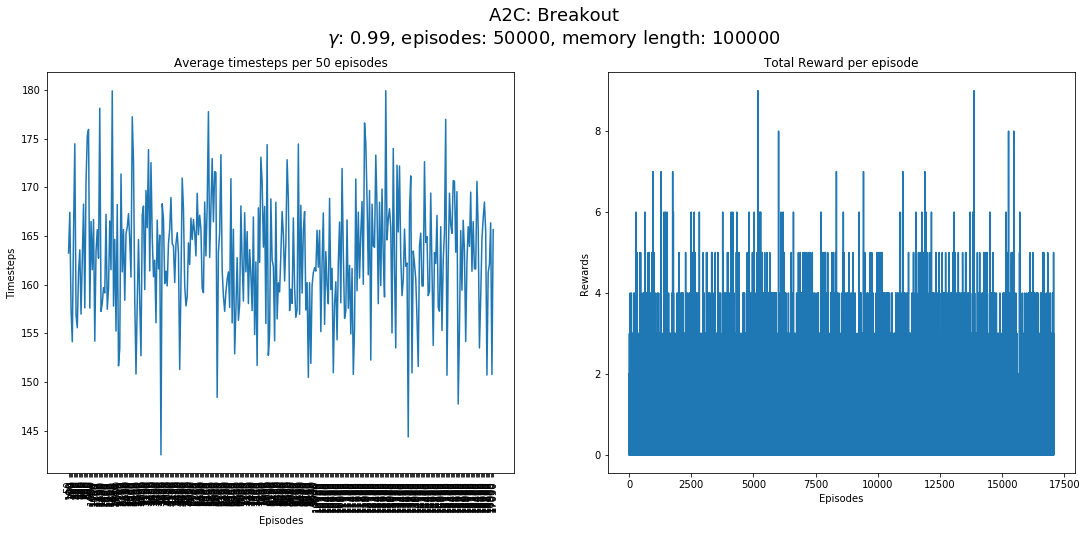

In [11]:
# Plot graphs
title = 'A2C: Breakout\n' + r'$\gamma$: {}, episodes: {}, memory length: {}'.format(discount_factor, episodes, memory_len)

plot_graphs(title, total_reward_arr, epsilon_decay_arr, cumulative_reward_arr, avg_timestep_arr, episodes)

In [18]:
test_total_reward_arr1 = agent.test_model(agent, env, test_episodes, perform_render=perform_render)

In [ ]:
fig = plt.figure(figsize=(20,5))
plt.plot(test_total_reward_arr1)
plt.title('Test time: Double Deep Q-Learning (Breakout) \nTotal reward per episode')
plt.xlabel('Episodes', fontsize=14)
plt.ylabel('Reward per episode', fontsize=14)
plt.xticks(np.arange(100), np.arange(1,101), rotation=90)
plt.show()